## Project: "The 15min Emergency"
This project will try to analyze the medical readness of washington DC, so see whether any residence or building in the city is under the reach of any medical service in the case of emergency, where one can reach the medical center within 15 min of walk or bike travel.

Our goal for this project will be to answer the following questions pertaining to easy access to medical services:
 - What is the overall current state of readiness of the city and neighboorhoods within it in respect to this "15min Emergency" goal?
 - Can we identify neighborhoods that share similar characteristics and group them together so that specific dedicated action plans can be defined to enable the "15 minutes" vision in these neighborhoods?

In [1]:
#importing all the libraries
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup as soup
from urllib.request import urlopen
import json
import requests
from pandas.io.json import json_normalize
import matplotlib.pyplot as plt

In [2]:
#importing the residence data of washington DC from local system
residence_df = pd.read_csv(r'C:\Users\PRK\Desktop\capstone IBM\DC_property.csv')

In [3]:
residence_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9142 entries, 0 to 9141
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   PM_PROPERTY_ID     9142 non-null   int64  
 1   PROPERTY_NAME      9142 non-null   object 
 2   ADDRESS_OF_RECORD  9140 non-null   object 
 3   POSTAL_CODE        8364 non-null   object 
 4   LATITUDE           9142 non-null   float64
 5   LONGITUDE          9142 non-null   float64
dtypes: float64(2), int64(1), object(3)
memory usage: 428.7+ KB


In [4]:
#Filtering only residence from the downtown of washington DC
downtown_df=residence_df[residence_df['POSTAL_CODE']=='20005']

In [5]:
downtown_df.reset_index()

index  PM_PROPERTY_ID                         PROPERTY_NAME  \
0        2         1034459                1090 Vermont Avenue NW   
1        3         3540220                  Cambridge Apartments   
2      121         3412123                   ! Engine Company 16   
3      145         2035970  The Henry J Kaiser Family Foundation   
4      175         2035970  The Henry J Kaiser Family Foundation   
..     ...             ...                                   ...   
807   8865         1492661             The CoStar Group Building   
808   8887         1043010                   1120 Vermont Avenue   
809   8912         1488373                         1275 K Street   
810   9073         3499934                Washington Plaza Hotel   
811   9080         3499934                Washington Plaza Hotel   

             ADDRESS_OF_RECORD POSTAL_CODE   LATITUDE  LONGITUDE  
0           1090 VERMONT AV NW       20005  38.903428 -77.033678  
1    1221 MASSACHUSETTS AVE NW       20005  38.904971 -77.029008  
2              1018 13TH ST NW       20005  38.903318 -77.030018  
3                 1330 G ST NW       20005  38.898063 -77.030934  
4                 1330 G ST NW       20005  38.898063 -77.030934  
..                         ...         ...        ...        ...  
807               1331 L ST NW       20005  38.904077 -77.030990  
808         1120 VERMONT AV NW       20005  38.904924 -77.032952  
809               1275 K ST NW       20005  38.902888 -77.029149  
810              10 THOMAS CIR       20005  38.906247 -77.030941  
811              10 THOMAS CIR       20005  38.906247 -77.030941  

[812 rows x 7 columns]

In [6]:
#saving the coordinated of each residence and removing the duplicate
downtown_coord = downtown_df[['LATITUDE', 'LONGITUDE']]
print(downtown_coord.shape)
downtown_coord = downtown_coord.drop_duplicates(inplace = False)
print(downtown_coord.shape)
downtown_coord.head()

(812, 2)
(427, 2)


LATITUDE  LONGITUDE
2    38.903428 -77.033678
3    38.904971 -77.029008
121  38.903318 -77.030018
145  38.898063 -77.030934
194  38.898056 -77.030932

In [7]:
#defining the foursquare api key
CLIENT_ID = 'DYWALHDQR14F3DOLF15S330FTVDXBHEXIJNZ5DS2DT1U51HA' 
CLIENT_SECRET = 'HBKWUMJP3R33ZWCMZJ2L23U5ELUH21EXCCIZLBH1VIYNPV5J' 
VERSION = '20180605'

In [9]:
#creating function to extract medical location in 1000m radius
def getVenues(lat, long, venue_cat, radius, limit):
    coor = lat + ',' + long
    venues_list=[]
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={}&categoryId={}&radius={}&limit={}'.format(
            CLIENT_ID, CLIENT_SECRET, VERSION, coor, venue_cat, radius, limit)
    results_tmp = requests.get(url).json()['response']
    
    #if empty
    if len(results_tmp) == 0:
        #print('empty')
        return([])
    
    #if groups
    if 'groups' in results_tmp.keys() and len(results_tmp['groups'][0]['items']) > 0:
        #print('group')
        results = results_tmp['groups'][0]['items']
    else: 
        return([])
    
    # loop through results set to build a list of venues with relevant information for our analysis. 
    for v in results:
        print('in loop')
        if 'postalCode' in v['venue']['location'].keys():
            if 'categories' in v['venue'].keys() and len(v['venue']['categories']) > 0:
                venues_list.append([v['venue']['id'], v['venue']['name'], v['venue']['location']['lat'], 
                v['venue']['location']['lng'], v['venue']['location']['postalCode'], 
                    v['venue']['categories'][0]['name'], v['venue']['categories'][0]['id']])
            else:
                venues_list.append([v['venue']['id'], v['venue']['name'], v['venue']['location']['lat'], 
                v['venue']['location']['lng'], v['venue']['location']['postalCode'], 'n/a', 'n/a'])
        
        elif 'categories' in v['venue'].keys() and len(v['venue']['categories']) > 0:
                venues_list.append([v['venue']['id'], v['venue']['name'], v['venue']['location']['lat'], 
                v['venue']['location']['lng'], 'n/a', 
                    v['venue']['categories'][0]['name'], v['venue']['categories'][0]['id']])
        else:
                venues_list.append([v['venue']['id'], v['venue']['name'], v['venue']['location']['lat'], 
                    v['venue']['location']['lng'], 'n/a', 'n/a', 'n/a'])
                
    print(venues_list[0])
    # Transform the list of results into a dataframe to be returned by the function.
    nearby_venues = pd.DataFrame([item for item in venues_list])
    nearby_venues.columns = [
        'Venue ID',
        'Venue Name', 
        'Venue Latitude', 
        'Venue Longitude', 
        'Venue Postal Code',
        'Venue Category',
        'Venue Category ID']
    
    return(nearby_venues)
    


In [10]:
#change cliet id and password if possible TRY 1000M IN NEXT RUN

med_venue_categories = '4bf58dd8d48988d177941735,4bf58dd8d48988d178941735,4bf58dd8d48988d196941735'
med_services = pd.DataFrame()
print('Start retrieving all medical services in 500m radius of residences coordinates.')
for index, row in downtown_coord.iterrows():
    print(index)
    med_services = med_services.append(getVenues(str(row['LATITUDE']), str(row['LONGITUDE']), med_venue_categories, 1000, 1000))

Start retrieving all medical services in 500m radius of residences coordinates.
2
grooup
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
['4efe35bfd5fb7fa2b90783f6', 'Washington Institute of Dermatologic Laser Surgery', 38.90258149676262, -77.03321

grooup
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
['5204faa8498ed71ec472eecb', 'Johns Hopkins Community Physicians', 38.90109420781294, -77.03231289201335, '20005', "Doctor's Office", '4bf58dd8d48988d177941735']
925
grooup
in loop
in loop
in l

grooup
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
['5204faa8498ed71ec472eecb', 'Johns Hopkins Community Physicians', 38.90109420781294, -77.03231289201335, '20005', "Doctor's Office", '4bf58dd8d48988d177941735']
1376
grooup
in loop
in loop
in 

grooup
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
['4b673010f964a52032402be3', 'Tsaknis Dental Group', 38.904655472705635, -77.0290394776558, '20005', "Dentist's Office", '4bf58dd8d48988d178941735']
1711
grooup
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop


grooup
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
['4c361bf0dfb0e21ee381aaa8', 'Dr. Daniel Cave, Dentist', 38.9041528398529, -77.03658514976242, '20036', "Dentist's Office", '4bf58dd8d48988d178941735']
2048
grooup
in loop
in loop
in loop
in lo

grooup
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
['5204faa8498ed71ec472eecb', 'Johns Hopkins Community Physicians', 38.90109420781294, -77.03231289201335, '20005', "Doctor's Office", '4bf58dd8d48988d177941735']
2297
grooup
in loop
in loop
in 

grooup
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
['4fda53f4e4b05909e049017a', 'Walgreens', 38.90814134465325, -77.03156769275665, '20005', "Doctor's Office", '4bf58dd8d48988d177941735']
2466
grooup
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
['4b673010f9

grooup
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
['4fda53f4e4b05909e049017a', 'Walgreens', 38.90814134465325, -77.03156769275665, '20005', "Doctor's Office", '4bf58dd8d48988d177941735']
2752
grooup
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in l

grooup
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
['5204faa8498ed71ec472eecb', 'Johns Hopkins Community Physicians', 38.90109420781294, -77.03231289201335, '20005', "Doctor's Office", '4bf58dd8d48988d177941735']
2912
grooup
in loop
in loop
in 

grooup
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
['4efe35bfd5fb7fa2b90783f6', 'Washington Institute of Dermatologic Laser Surgery', 38.90258149676262, -77.03321824394546, '20005', "Doctor's Office", '4bf58dd8d48988d177941735']
3066
grooup
in 

grooup
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
['4dde4aaa183877913999d7e4', 'City Dental DC', 38.9050631, -77.0290498, '20005', "Doctor's Office", '4bf58dd8d48988d177941735']
3325
grooup
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in lo

grooup
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
['4fda53f4e4b05909e049017a', 'Walgreens', 38.90814134465325, -77.03156769275665, '20005', "Doctor's Office", '4bf58dd8d48988d177941735']
3576
grooup
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in l

grooup
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
['4dde4aaa183877913999d7e4', 'City Dental DC', 38.9050631, -77.0290498, '20005', "Doctor's Office", '4bf58dd8d48988d177941735']
3649
grooup
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in lo

grooup
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
['4efe35bfd5fb7fa2b90783f6', 'Washington Institute of Dermatologic Laser Surgery', 38.90258149676262, -77.03321824394546, '20005', "Doctor's Office", '4bf58dd8d48988d177941735']
3789
grooup
in 

grooup
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
['582e08b60a4307645dfa1f1f', 'Washington Nutrition Group', 38.897976, -77.028561, '20005', "Doctor's Office", '4bf58dd8d48988d177941735']
3996
grooup
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in 

grooup
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
['5204faa8498ed71ec472eecb', 'Johns Hopkins Community Physicians', 38.90109420781294, -77.03231289201335, '20005', "Doctor's Office", '4bf58dd8d48988d177941735']
4162
grooup
in loop
in loop
in 

grooup
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
['4fda53f4e4b05909e049017a', 'Walgreens', 38.90814134465325, -77.03156769275665, '20005', "Doctor's Office", '4bf58dd8d48988d177941735']
4465
grooup
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in l

grooup
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
['52162ca711d2395d2a3b19af', 'Dc Light Dental', 38.89765167236328, -77.03093719482422, '20004', "Dentist's Office", '4bf58dd8d48988d178941735']
4640
grooup
in loop
in loop
in loop
in loop
in lo

grooup
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
['5204faa8498ed71ec472eecb', 'Johns Hopkins Community Physicians', 38.90109420781294, -77.03231289201335, '20005', "Doctor's Office", '4bf58dd8d48988d177941735']
4731
grooup
in loop
in loop
in 

grooup
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
['4fda53f4e4b05909e049017a', 'Walgreens', 38.90814134465325, -77.03156769275665, '20005', "Doctor's Office", '4bf58dd8d48988d177941735']
4949
grooup
in loop
in loop
in loop
in loop
in loop
in l

grooup
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
['4c361bf0dfb0e21ee381aaa8', 'Dr. Daniel Cave, Dentist', 38.9041528398529, -77.03658514976242, '20036', "Dentist's Office", '4bf58dd8d48988d178941735']
5105
grooup
in loop
in loop
in loop
in lo

grooup
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
['4dde4aaa183877913999d7e4', 'City Dental DC', 38.9050631, -77.0290498, '20005', "Doctor's Office", '4bf58dd8d48988d177941735']
5280
grooup
in loop
in loop
in loop
in loop
in loop
in loop
in lo

grooup
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
['4fda53f4e4b05909e049017a', 'Walgreens', 38.90814134465325, -77.03156769275665, '20005', "Doctor's Office", '4bf58dd8d48988d177941735']
5413
grooup
in loop
in loop
in loop
in loop
in loop
in l

grooup
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
['4efe35bfd5fb7fa2b90783f6', 'Washington Institute of Dermatologic Laser Surgery', 38.90258149676262, -77.03321824394546, '20005', "Doctor's Office", '4bf58dd8d48988d177941735']
5572
grooup
in 

grooup
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
['4fda53f4e4b05909e049017a', 'Walgreens', 38.90814134465325, -77.03156769275665, '20005', "Doctor's Office", '4bf58dd8d48988d177941735']
5782
grooup
in loop
in loop
in loop
in loop
in loop
in l

grooup
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
['5204faa8498ed71ec472eecb', 'Johns Hopkins Community Physicians', 38.90109420781294, -77.03231289201335, '20005', "Doctor's Office", '4bf58dd8d48988d177941735']
5875
grooup
in loop
in loop
in 

grooup
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
['5204faa8498ed71ec472eecb', 'Johns Hopkins Community Physicians', 38.90109420781294, -77.03231289201335, '20005', "Doctor's Office", '4bf58dd8d48988d177941735']
5967
grooup
in loop
in loop
in 

grooup
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
['55345967498e09dc327cc4c2', "Look Who's Talking", 38.90687561035156, -77.0340805053711, '20005', "Doctor's Office", '4bf58dd8d48988d177941735']
6103
grooup
in loop
in loop
in loop
in loop
in l

grooup
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
['4fda53f4e4b05909e049017a', 'Walgreens', 38.90814134465325, -77.03156769275665, '20005', "Doctor's Office", '4bf58dd8d48988d177941735']
6326
grooup
in loop
in loop
in loop
in loop
in loop
in l

grooup
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
['4c361bf0dfb0e21ee381aaa8', 'Dr. Daniel Cave, Dentist', 38.9041528398529, -77.03658514976242, '20036', "Dentist's Office", '4bf58dd8d48988d178941735']
6466
grooup
in loop
in loop
in loop
in lo

grooup
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
['5204faa8498ed71ec472eecb', 'Johns Hopkins Community Physicians', 38.90109420781294, -77.03231289201335, '20005', "Doctor's Office", '4bf58dd8d48988d177941735']
6523
grooup
in loop
in loop
in 

grooup
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
['5204faa8498ed71ec472eecb', 'Johns Hopkins Community Physicians', 38.90109420781294, -77.03231289201335, '20005', "Doctor's Office", '4bf58dd8d48988d177941735']
6636
grooup
in loop
in loop
in 

grooup
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
['582e08b60a4307645dfa1f1f', 'Washington Nutrition Group', 38.897976, -77.028561, '20005', "Doctor's Office", '4bf58dd8d48988d177941735']
6746
grooup
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in 

grooup
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
['4ba269fcf964a52094f637e3', 'DC Light Dental', 38.896729, -77.030787, '20045', "Dentist's Office", '4bf58dd8d48988d178941735']
6837
grooup
in loop
in loop
in loop
in loop
in loop
in loop
in lo

grooup
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
['5204faa8498ed71ec472eecb', 'Johns Hopkins Community Physicians', 38.90109420781294, -77.03231289201335, '20005', "Doctor's Office", '4bf58dd8d48988d177941735']
7032
grooup
in loop
in loop
in 

grooup
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
['4efe35bfd5fb7fa2b90783f6', 'Washington Institute of Dermatologic Laser Surgery', 38.90258149676262, -77.03321824394546, '20005', "Doctor's Office", '4bf58dd8d48988d177941735']
7143
grooup
in 

grooup
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
['5214d9667e4847b1ea7b5df9', 'Alcohol & Drug Rehab Washington', 38.9029541015625, -77.02763366699219, '20005', 'Hospital', '4bf58dd8d48988d196941735']
7245
grooup
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loo

grooup
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
['5214d9667e4847b1ea7b5df9', 'Alcohol & Drug Rehab Washington', 38.9029541015625, -77.02763366699219, '20005', 'Hospital', '4bf58dd8d48988d196941735']
7341
grooup
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loo

grooup
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
['5204faa8498ed71ec472eecb', 'Johns Hopkins Community Physicians', 38.90109420781294, -77.03231289201335, '20005', "Doctor's Office", '4bf58dd8d48988d177941735']
7622
grooup
in loop
in loop
in 

grooup
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
['5204faa8498ed71ec472eecb', 'Johns Hopkins Community Physicians', 38.90109420781294, -77.03231289201335, '20005', "Doctor's Office", '4bf58dd8d48988d177941735']
7864
grooup
in loop
in loop
in 

grooup
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
['55345967498e09dc327cc4c2', "Look Who's Talking", 38.90687561035156, -77.0340805053711, '20005', "Doctor's Office", '4bf58dd8d48988d177941735']
7998
grooup
in loop
in loop
in loop
in loop
in l

grooup
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
['5204faa8498ed71ec472eecb', 'Johns Hopkins Community Physicians', 38.90109420781294, -77.03231289201335, '20005', "Doctor's Office", '4bf58dd8d48988d177941735']
8164
grooup
in loop
in loop
in 

grooup
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
['5bab873200b068002d98c50c', 'SPA Dental Group', 38.9015041, -77.0282593, '20005', "Dentist's Office", '4bf58dd8d48988d178941735']
8299
grooup
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in

grooup
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
['4c361bf0dfb0e21ee381aaa8', 'Dr. Daniel Cave, Dentist', 38.9041528398529, -77.03658514976242, '20036', "Dentist's Office", '4bf58dd8d48988d178941735']
8532
grooup
in loop
in loop
in loop
in lo

grooup
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
['5bab873200b068002d98c50c', 'SPA Dental Group', 38.9015041, -77.0282593, '20005', "Dentist's Office", '4bf58dd8d48988d178941735']
9073
grooup
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in

In [11]:
med_services.shape

(38750, 8)

In [269]:
#removing duplicates
med_services = med_services.drop_duplicates()
med_services.shape

#reseting the index
reset index
med_services.reset_index(inplace = True)

In [86]:
#the category of medical service
print('Unique categories of medical services in our medical services dataset: ', med_services['Venue Category'].unique())

Unique categories of medical services in our medical services dataset:  ["Doctor's Office" "Dentist's Office" 'Hospital' 'Health & Beauty Service']


In [273]:
#Remove nan and extra category
print('Unique categories of medical services in our medical services dataset: ', med_services['Venue Category'].unique())
med_services.drop(med_services[(med_services['Venue Category'] == 'Coworking Space') 
                            | (med_services['Venue Category'] == 'nan')].index, inplace = True)
print('We confirm this deletion by checking the remaining unique categories of medical services in our medical services dataset: ', med_services['Venue Category'].unique())


We confirm this deletion by checking the remaining unique categories of medical services in our medical services dataset:  ["Doctor's Office" "Dentist's Office" 'Hospital' 'Health & Beauty Service'
 nan]


In [88]:
med_services.rename(columns = {0:'drop'}, inplace = True)
med_services.head()

level_0  index    Venue Category         Venue Category ID  \
0        0      0   Doctor's Office  4bf58dd8d48988d177941735   
1        1      1   Doctor's Office  4bf58dd8d48988d177941735   
2        2      2   Doctor's Office  4bf58dd8d48988d177941735   
3        3      3  Dentist's Office  4bf58dd8d48988d178941735   
4        4      4   Doctor's Office  4bf58dd8d48988d177941735   

                   Venue ID  Venue Latitude  Venue Longitude  \
0  4efe35bfd5fb7fa2b90783f6       38.902581       -77.033218   
1  4cc5a9aa01fb236ac3eeb2ba       38.902142       -77.032972   
2  4babad91f964a5208bbf3ae3       38.902397       -77.033494   
3  4c361bf0dfb0e21ee381aaa8       38.904153       -77.036585   
4  5204faa8498ed71ec472eecb       38.901094       -77.032313   

                                          Venue Name Venue Postal Code  
0  Washington Institute of Dermatologic Laser Sur...             20005  
1                                        Visual Eyes               n/a  
2                    Washington Center for Dentistry             20005  
3                           Dr. Daniel Cave, Dentist             20036  
4                 Johns Hopkins Community Physicians             20005

In [115]:
#remove the null values
med_services['Venue Category'].dropna(inplace=True, axis=0)

In [116]:
med_services['Venue Category'].unique()

array(["Doctor's Office", "Dentist's Office", 'Hospital',
       'Health & Beauty Service'], dtype=object)

In [118]:
#check size and reset index
med_services.reset_index(inplace = True, drop=True)
print(med_services.shape)

(271, 9)


In [119]:
print('Unique categories of medical services in our medical services dataset: ', med_services['Venue Category'].unique())

Unique categories of medical services in our medical services dataset:  ["Doctor's Office" "Dentist's Office" 'Hospital' 'Health & Beauty Service'
 nan]


In [47]:
#import to local system for faster retrieval of data
med_services.head()
med_services.to_csv(r'C:\Users\PRK\Desktop\capstone IBM\med_services.csv')

## applying 15 min rule

In [142]:
med_cat = pd.DataFrame(med_services['Venue Category'].unique())
med_cat.rename(columns = {0:'category'}, inplace = True)
met_cat = med_cat.dropna(axis=0)

#fake key
med_cat['fake_key'] = 1
downtown_df['fake_key'] = 1

#merge
med_downtown = pd.merge(downtown_df, med_cat, on=['fake_key'])
med_downtown.drop('fake_key', axis=1, inplace=True)

print(med_downtown.shape)

(4065, 7)


C:\Users\PRK\anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [274]:
med_downtown.head()

PM_PROPERTY_ID      PROPERTY_NAME ADDRESS_OF_RECORD POSTAL_CODE  \
1756            2267  600 Thirteenth St   0600 13TH ST NW       20005   
3228            2267  600 Thirteenth St   0600 13TH ST NW       20005   
3212            2267  600 Thirteenth St   0600 13TH ST NW       20005   
1757            2267  600 Thirteenth St   0600 13TH ST NW       20005   
1758            2267  600 Thirteenth St   0600 13TH ST NW       20005   

       LATITUDE  LONGITUDE                 category  traveltime  minindex  \
1756  38.897841 -77.029995         Dentist's Office    1.012534      46.0   
3228  38.897841 -77.029995  Health & Beauty Service   11.333918      52.0   
3212  38.897849 -77.029872                 Hospital    7.189272     101.0   
1757  38.897841 -77.029995                 Hospital    7.241994     101.0   
1758  38.897841 -77.029995  Health & Beauty Service   11.333918      52.0   

      15minFlag  
1756       True  
3228       True  
3212       True  
1757       True  
1758       True

In [151]:
med_downtown.dropna(axis=0, inplace=True)

In [152]:
#Function for minimum time
from geopy.distance import distance
def min_travel_time(rlat, rlong, service, speed):
    min_time=9999999
    minindex=0
    
    for i in service.index:
        residence_coor = rlat, rlong
        med_service_coor = service.loc[i, 'Venue Latitude'], service.loc[i, 'Venue Longitude']
        
        dist = distance(residence_coor, med_service_coor).km
        #travel time
        travel_time = (dist / speed) * 60
        
        if travel_time < min_time:
            min_time = travel_time
            minindex=i
    
    return min_time, minindex
        


In [153]:
#calculating min distance
speed = 5

for category in med_cat['category'].unique():
    for index, row in med_downtown.iterrows():
        if row['category'] == category:
            min_travel = min_travel_time(row['LATITUDE'], row['LONGITUDE'], med_services[med_services['Venue Category']==category], speed)
            med_downtown.loc[index, 'traveltime'] = min_travel[0]
            med_downtown.loc[index, 'minindex'] = min_travel[1]
            
#med_downtown.astype({'minindex': 'int'}).dtypes
print(med_downtown.shape)


(3252, 9)


In [156]:
#med_downtown.astype({'minindex': 'int'}).dtypes
med_downtown.head()

PM_PROPERTY_ID           PROPERTY_NAME          ADDRESS_OF_RECORD  \
0         1034459  1090 Vermont Avenue NW         1090 VERMONT AV NW   
1         1034459  1090 Vermont Avenue NW         1090 VERMONT AV NW   
2         1034459  1090 Vermont Avenue NW         1090 VERMONT AV NW   
3         1034459  1090 Vermont Avenue NW         1090 VERMONT AV NW   
5         3540220    Cambridge Apartments  1221 MASSACHUSETTS AVE NW   

  POSTAL_CODE   LATITUDE  LONGITUDE                 category  traveltime  \
0       20005  38.903428 -77.033678          Doctor's Office    1.027463   
1       20005  38.903428 -77.033678         Dentist's Office    0.080287   
2       20005  38.903428 -77.033678                 Hospital    6.322827   
3       20005  38.903428 -77.033678  Health & Beauty Service    7.344060   
5       20005  38.904971 -77.029008          Doctor's Office    0.130584   

   minindex  15minFlag  
0     105.0       True  
1     103.0       True  
2     101.0       True  
3      52.0       True  
5      11.0       True

In [157]:
med_downtown['15minFlag'] = (med_downtown['traveltime'] <= 15)
med_downtown.head()

PM_PROPERTY_ID           PROPERTY_NAME          ADDRESS_OF_RECORD  \
0         1034459  1090 Vermont Avenue NW         1090 VERMONT AV NW   
1         1034459  1090 Vermont Avenue NW         1090 VERMONT AV NW   
2         1034459  1090 Vermont Avenue NW         1090 VERMONT AV NW   
3         1034459  1090 Vermont Avenue NW         1090 VERMONT AV NW   
5         3540220    Cambridge Apartments  1221 MASSACHUSETTS AVE NW   

  POSTAL_CODE   LATITUDE  LONGITUDE                 category  traveltime  \
0       20005  38.903428 -77.033678          Doctor's Office    1.027463   
1       20005  38.903428 -77.033678         Dentist's Office    0.080287   
2       20005  38.903428 -77.033678                 Hospital    6.322827   
3       20005  38.903428 -77.033678  Health & Beauty Service    7.344060   
5       20005  38.904971 -77.029008          Doctor's Office    0.130584   

   minindex  15minFlag  
0     105.0       True  
1     103.0       True  
2     101.0       True  
3      52.0       True  
5      11.0       True

In [168]:
#total unique properties
med_downtown['PM_PROPERTY_ID'].nunique()
med_downtown.shape

(3248, 10)

In [167]:
#removing the outlier
med_downtown = med_downtown[med_downtown.PM_PROPERTY_ID != 1]

### Analysis of the neighborhood

In [169]:
#number of medical service under 15min criteria
med_downtown[med_downtown['15minFlag']].groupby('category')['PM_PROPERTY_ID'].nunique()
#print('number of medical service within 15 min:' + str())

category
Dentist's Office           193
Doctor's Office            193
Health & Beauty Service    193
Hospital                   193
Name: PM_PROPERTY_ID, dtype: int64

In [170]:
#property that does not meet 15 min criteria
med_downtown[med_downtown['15minFlag']==False]

Empty DataFrame
Columns: [PM_PROPERTY_ID, PROPERTY_NAME, ADDRESS_OF_RECORD, POSTAL_CODE, LATITUDE, LONGITUDE, category, traveltime, minindex, 15minFlag]
Index: []

Average Travel Time =  4.9 minutes
Median Travel Time =  3.9 minutes


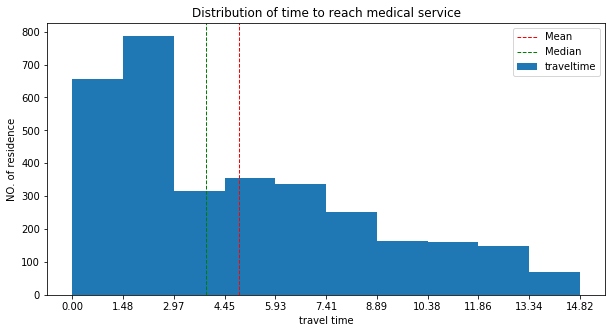

In [171]:
#Travel time across all medical service
fig = plt.figure()

count, bins = np.histogram(med_downtown['traveltime'])

ax = med_downtown['traveltime'].plot(kind='hist', xticks=bins, figsize=(10,5))
ax.set_title('Distribution of time to reach medical service')
ax.set_xlabel('travel time')
ax.set_ylabel('NO. of residence')

ax.axvline(med_downtown['traveltime'].mean(), linestyle='dashed', color='r', linewidth=1, label='Mean')
ax.axvline(med_downtown['traveltime'].median(), linestyle='dashed', color='g', linewidth=1, label='Median')

ax.legend()

print('Average Travel Time = ', round(med_downtown['traveltime'].mean(), 1), 'minutes')
print('Median Travel Time = ', round(med_downtown['traveltime'].median(), 1), 'minutes')

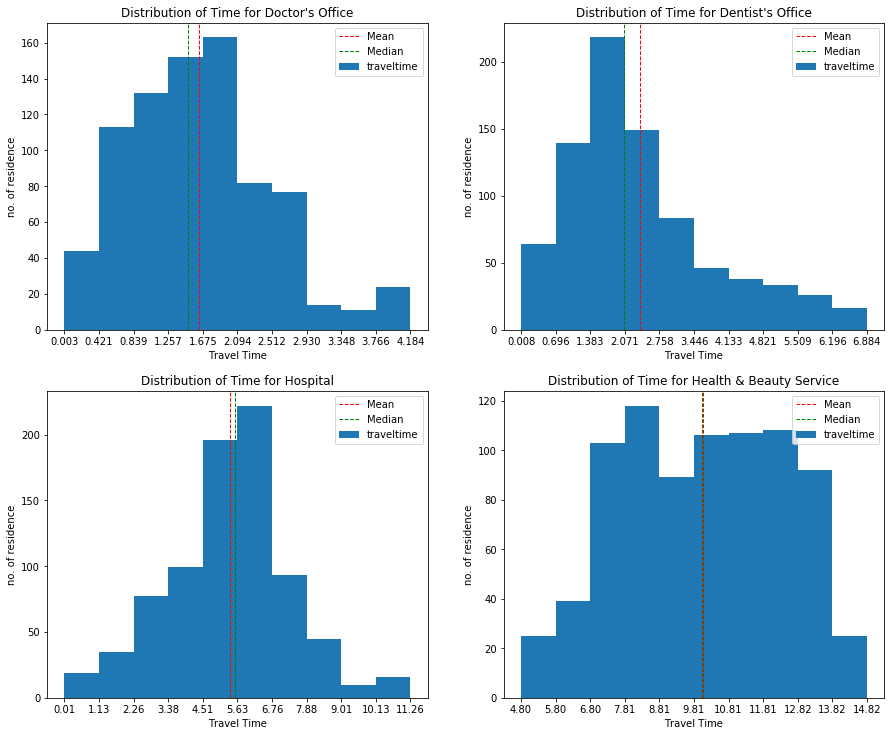

In [177]:
#Distribution of travel times by medical service category.

import math
med_cat_1 = med_cat.dropna(axis=0)
fig = plt.figure(figsize=(15,15))
ax=[]

for i in range(len(med_cat_1.index)):
    ax.append(fig.add_subplot(math.ceil(len(med_cat_1.index)/2), 2, i+1))
    
j=0
for category in med_cat_1['category']:
    count, bins = np.histogram(med_downtown[med_downtown['category']==category]['traveltime'])
    med_downtown[med_downtown['category']==category]['traveltime'].plot(kind='hist', xticks=bins, ax=ax[j])
    ax[j].set_title('Distribution of Time for ' + category)
    ax[j].set_xlabel('Travel Time')
    ax[j].set_ylabel('no. of residence')
    ax[j].axvline(med_downtown[med_downtown['category'] == category]['traveltime'].mean(), linestyle='dashed', color='r', linewidth=1, label='Mean')
    ax[j].axvline(med_downtown[med_downtown['category'] == category]['traveltime'].median(), linestyle='dashed', color='g', linewidth=1, label='Median')
    
    ax[j].legend()
    j=j+1
plt.subplots_adjust(top=0.75)

- The maximum time to reach a doctor's office in the downtown of DC will take less than 5 minutes with average travel time been under a minute.
- For a case of bigger emergency such as an accident, the Hospital reach be reached within maximum time of 12 minutes with average time in downtown is 5 minutes

In [186]:
#visualisation on map

import folium
#center point
downtown_center = [38.905342, -77.036489]
map_dc = folium.Map(location=downtown_center, zoom_start=14.5)

color = ['orangered', 'greenyellow']

#adding residence points
for res_id, lat, long, flag in zip(med_downtown['PM_PROPERTY_ID'], med_downtown['LATITUDE'], med_downtown['LONGITUDE'], med_downtown['15minFlag']):
    label = folium.Popup('Residence ID:' + str(res_id) + ' / 15 Min Readiness: ' + str(flag), parse_html=True)
    folium.CircleMarker(
        [lat,long],
        radius=3,
        popup=label,
        color=color[int(flag)],
        fill=True,
        fill_color=color[int(flag)],
        fill_opacity=1).add_to(map_dc)

print('Residences meeting the 15 minutes objective for all medical services are indicated in green on the map.')
print('All of the residence in the downtown are within the range of 15 min of a medical service')
map_dc
    
    

## clustering the residence

In [207]:
#performing one hot encoding
med_residence_temp = med_downtown[['PM_PROPERTY_ID', 'category', '15minFlag']]
med_residence_temp['category_flag'] = med_residence_temp['category'] + '_' + med_residence_temp['15minFlag'].astype(str)

medserv_onehot = pd.get_dummies(med_residence_temp['category_flag'], prefix="", prefix_sep="")
medserv_onehot['PROPERTY_ID'] = med_downtown['PM_PROPERTY_ID']

fixed_columns = [medserv_onehot.columns[-1]] + list(medserv_onehot.columns[:-1])
medserv_onehot = medserv_onehot[fixed_columns]
medserv_onehot_final = pd.DataFrame()
medserv_onehot_final = medserv_onehot.groupby('PROPERTY_ID').sum()

# We sort this dataframe on the Residence ID.
# This will help later when we match the clustering labels calculated for these residences to the final_res_df dataframe.
#medserv_onehot_final.sort_values(by='PROPERTY_ID', ascending=True, inplace=True)

print('Dataframe resulting of one hot encoding process:')
medserv_onehot_final.head()


Dataframe resulting of one hot encoding process:


C:\Users\PRK\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Dentist's Office_True  Doctor's Office_True  \
PROPERTY_ID                                                
2267                             6                     6   
16885                            5                     5   
17736                            4                     4   
19680                            5                     5   
1034332                          6                     6   

             Health & Beauty Service_True  Hospital_True  
PROPERTY_ID                                               
2267                                    6              6  
16885                                   5              5  
17736                                   4              4  
19680                                   5              5  
1034332                                 6              6

In [215]:
#clustering using Kmeans
from sklearn.cluster import KMeans

kclusters = 5

med_cluster = medserv_onehot_final

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(med_cluster)

# check cluster labels generated for each row in the dataframe
print("We take a look at the first 10 labels that have been assigned as a result of this clustering:")
kmeans.labels_[0:9] 

We take a look at the first 10 labels that have been assigned as a result of this clustering:


array([2, 0, 0, 0, 2, 2, 1, 2, 2])

In [218]:
print('Number of labels generated: ', len(kmeans.labels_))

Number of labels generated:  193


In [235]:
tmp_res_flag = med_downtown.groupby(['PM_PROPERTY_ID'], as_index=False)['15minFlag'].prod()
print('First few records of this dataframe:')
tmp_res_flag.head()

First few records of this dataframe:


PM_PROPERTY_ID  15minFlag
0            2267       True
1           16885       True
2           17736       True
3           19680       True
4         1034332       True

In [239]:
final_res_df = downtown_df.join(tmp_res_flag.set_index('PM_PROPERTY_ID'), on='PM_PROPERTY_ID')

# We drop the tmpkey column that we do not need anymore
final_res_df.drop(['fake_key'], axis=1, inplace=True)
final_res_df['PM_PROPERTY_ID'].nunique()
final_res_df = final_res_df[final_res_df.PM_PROPERTY_ID != 1]

In [238]:
#we assign the clustering labels they match the residence ID they were calculated for

final_res_df.sort_values(by='PM_PROPERTY_ID', ascending=True, inplace=True)

tmp_res_flag.insert(0, 'Cluster Labels', kmeans.labels_)
print('First 5 records of our updated dataframe:')
tmp_res_flag.head()

First 5 records of our updated dataframe:


Cluster Labels  PM_PROPERTY_ID  15minFlag
0               2            2267       True
1               0           16885       True
2               0           17736       True
3               0           19680       True
4               2         1034332       True

In [240]:
final_res_df.head()

PM_PROPERTY_ID                         PROPERTY_NAME  \
2           1034459                1090 Vermont Avenue NW   
3           3540220                  Cambridge Apartments   
121         3412123                   ! Engine Company 16   
145         2035970  The Henry J Kaiser Family Foundation   
175         2035970  The Henry J Kaiser Family Foundation   

             ADDRESS_OF_RECORD POSTAL_CODE   LATITUDE  LONGITUDE  \
2           1090 VERMONT AV NW       20005  38.903428 -77.033678   
3    1221 MASSACHUSETTS AVE NW       20005  38.904971 -77.029008   
121            1018 13TH ST NW       20005  38.903318 -77.030018   
145               1330 G ST NW       20005  38.898063 -77.030934   
175               1330 G ST NW       20005  38.898063 -77.030934   

     Cluster Labels 15minFlag  
2               2.0      True  
3               2.0      True  
121             0.0      True  
145             0.0      True  
175             0.0      True

In [246]:
#visualing clusters on map

import matplotlib.cm as cm
import matplotlib.colors as colors


downtown_center = [38.905342, -77.036489]
map_cluster = folium.Map(location=downtown_center, zoom_start=14.5)

# set color scheme for the clusters
cluster_color_tbl = []
x = np.arange(kclusters)
y = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(y)))
cluster_color_tbl = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
for res_id, lat, lon, cluster in zip(final_res_df['PM_PROPERTY_ID'], final_res_df['LATITUDE'], final_res_df['LONGITUDE'], final_res_df['Cluster Labels']):
    label = folium.Popup('Residence ID:' + str(res_id) + ' / Cluster: ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=cluster_color_tbl[int(cluster)],
        fill=True,
        fill_color=cluster_color_tbl[int(cluster)],
        fill_opacity=0.7).add_to(map_cluster)

print('Click on a marker to see the cluster number associated to the residence.')
map_cluster

Click on a marker to see the cluster number associated to the residence.


### cluster analysis

In [247]:
med_cluster.insert(0, 'Cluster Labels', kmeans.labels_)

In [248]:
# We create a simplified dataframe with just the columns that we need

res_med_simple = pd.DataFrame()
res_med_simple = med_cluster.loc[:, med_cluster.columns.str.contains('Cluster Labels') | med_cluster.columns.str.contains('_True')]

In [251]:
# Now we group this dataframe by cluster and calculate the number of residences with a medical services 15 minutes flag = TRUE
res_med_labels = res_med_simple.groupby(['Cluster Labels'], as_index=False).sum()
col_names = res_med_simple.columns.tolist()
new_col_names = []
for i,v in enumerate(col_names):
    if v[-5:] == '_True':
        res_med_labels.rename(columns={v: v[0:len(v)-5]}, inplace=True) 

print('This is the dataframe that we can now use to generate bar graphs for each cluster:')
res_med_labels.head()

This is the dataframe that we can now use to generate bar graphs for each cluster:


Cluster Labels  Dentist's Office  Doctor's Office  Health & Beauty Service  \
0               0             239.0            239.0                    239.0   
1               1              67.0             67.0                     67.0   
2               2             444.0            444.0                    444.0   
3               3              35.0             35.0                     35.0   
4               4              27.0             27.0                     27.0   

   Hospital  
0     239.0  
1      67.0  
2     444.0  
3      35.0  
4      27.0

In [254]:
# prepare a dataframe with the count of residences per cluster
res_count_label = pd.DataFrame()
res_count_label = final_res_df.groupby(['Cluster Labels'], as_index=False).count()
res_count_label = res_count_label[['Cluster Labels', 'PM_PROPERTY_ID']]

print('Dataframe containing the number of residences per cluster:')
res_count_label.head()

Dataframe containing the number of residences per cluster:


Cluster Labels  PM_PROPERTY_ID
0             0.0             239
1             1.0              67
2             2.0             444
3             3.0              35
4             4.0              27

Text(0, 0.5, 'No. of residence')

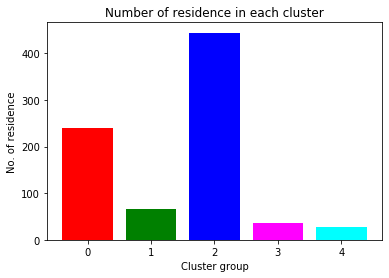

In [268]:
#plotting the number of residence in each clusters

plt.bar(range(len(res_count_label)), res_count_label['PM_PROPERTY_ID'],color=['red', 'green','blue','magenta','cyan'])
plt.title('Number of residence in each cluster')
plt.xlabel('Cluster group')
plt.ylabel('No. of residence')

Here we see the distribution of the clusters, where we observe the highest number of residence fall under the Cluster 2 and Cluster 4 has the least number of residence

### Conclusion

- For the neighborhood that we selected for this project that is downtown, DC, we have been able to determine the "15 minutes" readiness of these neighborhood, at the residence level, by type of medical service. We obtained some numerical results and were also able to visualize on a map these results.
- We also identified common readiness characteristics shared by residences and even neighborhoods within the districts via a clustering exercise, supplemented by a map visualization of the clusters.
- We confirmed that every residence in the downtown, is within the reach of every type of medical service/category required within the 15 minutes of walk.